<a href="https://colab.research.google.com/github/alex-petrov-git/math_ML_course/blob/main/hometask_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

In [ ]:
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

feature_names = X.columns

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

## 1. Разведочный анализ


### 1.1 Обзор данных

In [ ]:
X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,1.498365,1.061370,0.219902,1.138874,0.728473,1.055893,-0.824451,0.711038,0.547482,-0.061449
1,-0.228858,1.061370,-0.419366,-0.710591,-0.424929,0.272425,-1.529791,1.484286,-0.019757,0.367236
2,0.085182,-0.942179,1.018987,1.992473,-0.309589,-0.326699,-0.119111,-0.062210,0.331237,-0.318660
3,-0.621409,-0.942179,-0.784662,-0.639458,-1.174640,-1.215508,0.664600,-0.835458,-1.069682,-2.719299
4,-0.542899,-0.942179,-1.423930,-1.706457,-0.799784,-1.110167,1.291569,-1.608706,-0.802859,-0.918820


In [ ]:
y_train.head()

,target
17,144.0
66,150.0
137,280.0
245,125.0
31,59.0


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 353 entries, 17 to 102
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     353 non-null    float64
 1   sex     353 non-null    float64
 2   bmi     353 non-null    float64
 3   bp      353 non-null    float64
 4   s1      353 non-null    float64
 5   s2      353 non-null    float64
 6   s3      353 non-null    float64
 7   s4      353 non-null    float64
 8   s5      353 non-null    float64
 9   s6      353 non-null    float64
dtypes: float64(10)
memory usage: 30.3 KB


### 1.2 Распределение данных

In [ ]:
X_train.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,0.001442,0.000184,0.001736,0.001179,-0.000556,-0.000806,-0.000989,0.000377,0.001216,0.001891
std,0.046334,0.047644,0.047275,0.048469,0.047786,0.047631,0.047044,0.047790,0.047828,0.048380
min,-0.107226,-0.044642,-0.089197,-0.112399,-0.108893,-0.115613,-0.102307,-0.076395,-0.126097,-0.137767
25%,-0.030942,-0.044642,-0.032073,-0.036656,-0.035968,-0.032629,-0.032356,-0.039493,-0.033246,-0.030072
50%,0.009016,-0.044642,-0.005128,-0.005670,-0.004321,-0.004132,-0.006584,-0.002592,-0.000612,0.003064
75%,0.038076,0.050680,0.032595,0.035644,0.025950,0.027183,0.026550,0.034309,0.033654,0.032059
max,0.110727,0.050680,0.160855,0.132044,0.153914,0.198788,0.181179,0.185234,0.133597,0.135612


In [ ]:
X_train.nunique()

,0
age,56
sex,2
bmi,153
bp,91
s1,132
s2,259
s3,60
s4,54
s5,163
s6,56


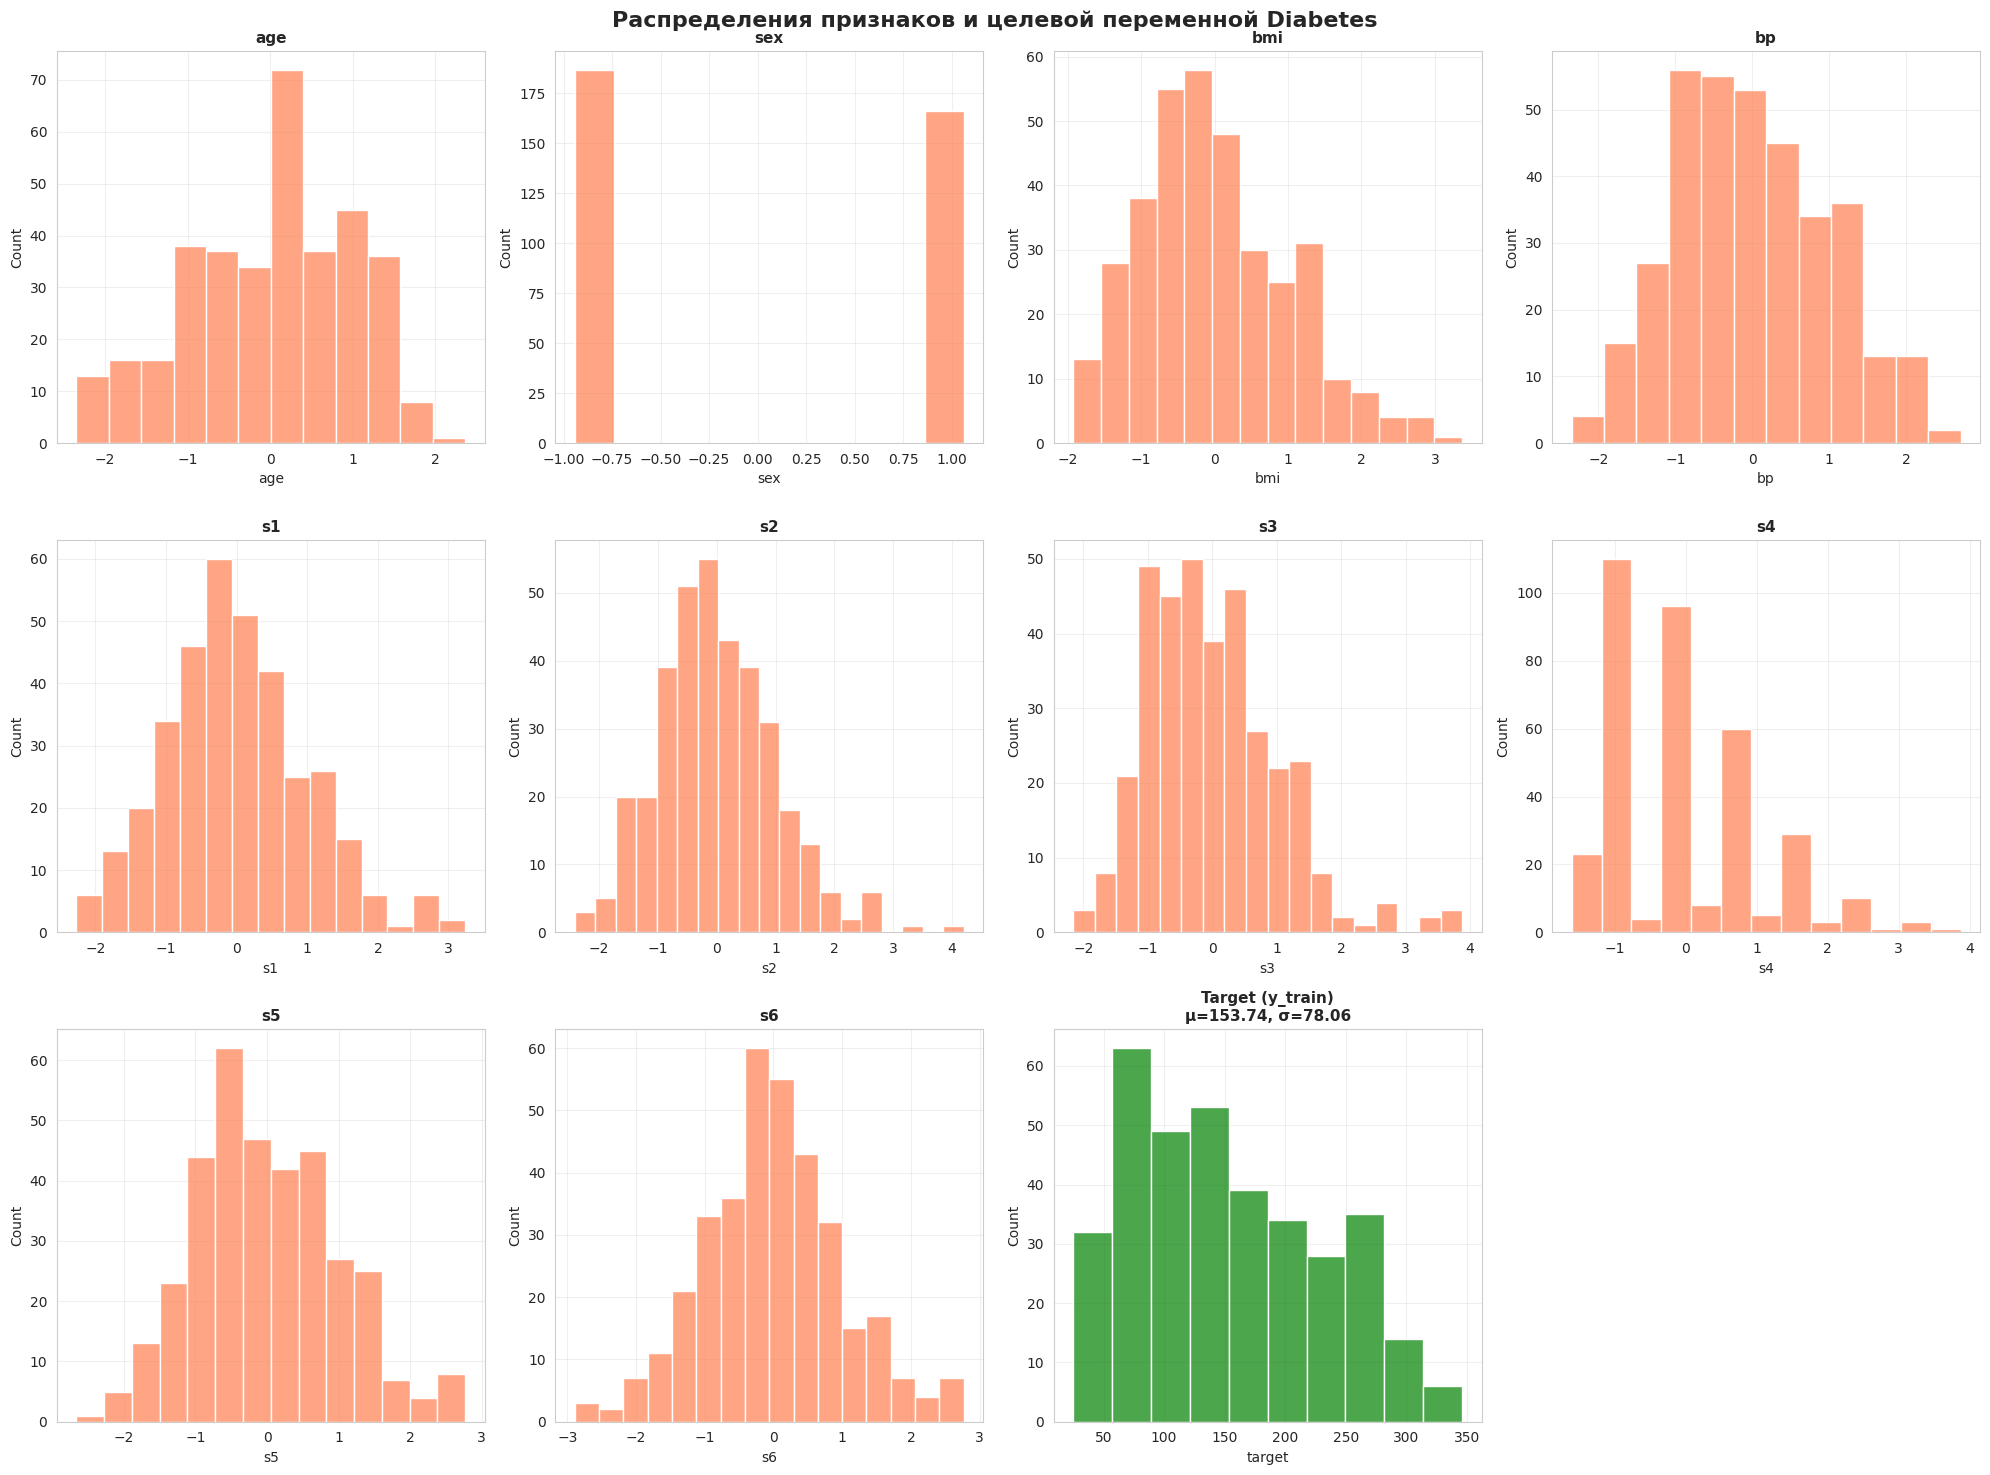

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

for i, column in enumerate(X_train.columns):
    sns.histplot(data=X_train, x=column, ax=axes[i], color='coral', alpha=0.7)
    axes[i].set_title(f'{column}', fontsize=11, fontweight='bold')
    axes[i].grid(alpha=0.3)

sns.histplot(data=y_train, ax=axes[len(X_train.columns)], color='green', alpha=0.7)
target_stats = f'Target (y_train)\nμ={y_train.mean():.2f}, σ={y_train.std():.2f}'
axes[len(X_train.columns)].set_title(target_stats, fontsize=11, fontweight='bold')
axes[len(X_train.columns)].set_xlabel('target')
axes[len(X_train.columns)].grid(alpha=0.3)

for j in range(len(X_train.columns) + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Распределения признаков и целевой переменной Diabetes',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

### 1.3 Корреляционная матрица

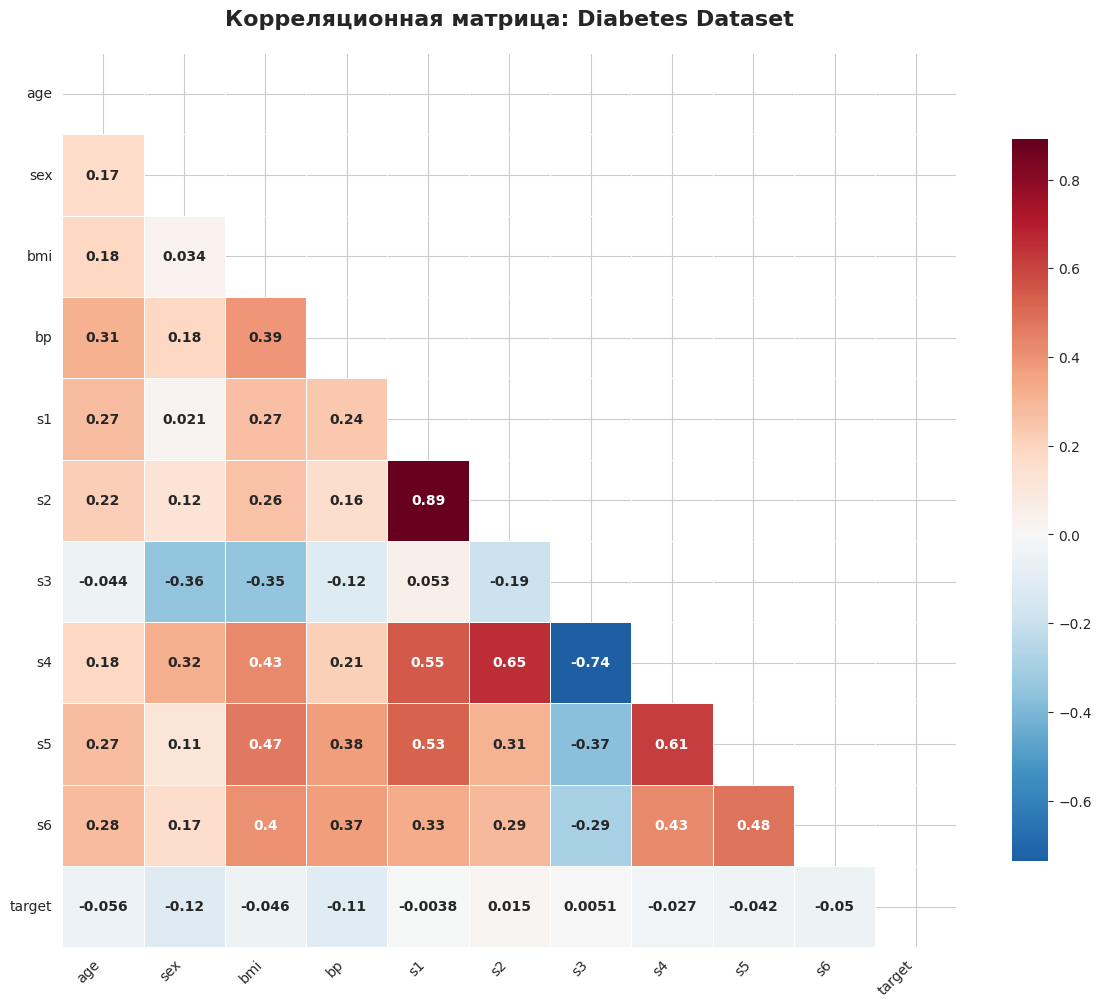

In [ ]:
df = X_train.copy()
df['target'] = y_train

plt.figure(figsize=(12, 10))

mask = np.triu(np.ones_like(df.corr(), dtype=bool))

heatmap = sns.heatmap(df.corr(),
                      mask=mask,
                      annot=True,
                      cmap='RdBu_r',
                      center=0,
                      square=True,
                      linewidths=0.5,
                      cbar_kws={'shrink': 0.8},
                      annot_kws={'size': 10, 'weight': 'bold'})

plt.title('Корреляционная матрица: Diabetes Dataset',
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10)

plt.tight_layout()
plt.show()

### 1.4. Выводы

1. Данные уже масштабированные
2. Задача регрессии

## 2. Обучение и применение модели

### 2.1 Обучение линейных моделей

In [ ]:
loo = LeaveOneOut()

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)

print(f"MSE для LinearRegression: {lr_mse:.2f}")

MSE для LinearRegression: 2900.19


In [ ]:
ridge = Ridge()
parameters = {'alpha': np.logspace(-4, 2, 100)}

ridge_cv = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=loo)
ridge_cv.fit(X_train, y_train)

print(f"Лучший параметр alpha для Ridge: {ridge_cv.best_params_['alpha']:.4f}")

ridge_pred = ridge_cv.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(f"MSE для Ridge: {ridge_mse:.2f}")

Лучший параметр alpha для Ridge: 1.1498
MSE для Ridge: 2891.21


In [ ]:
lasso = Lasso(max_iter=10000)
parameters = {'alpha': np.logspace(-4, 2, 100)}

lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=loo)
lasso_cv.fit(X_train, y_train)

print(f"Лучший параметр alpha для Lasso: {lasso_cv.best_params_['alpha']:.4f}")

lasso_pred = lasso_cv.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print(f"MSE для Lasso: {lasso_mse:.2f}")

Лучший параметр alpha для Lasso: 0.1233
MSE для Lasso: 2883.05


### 2.2 Визуализация результатов

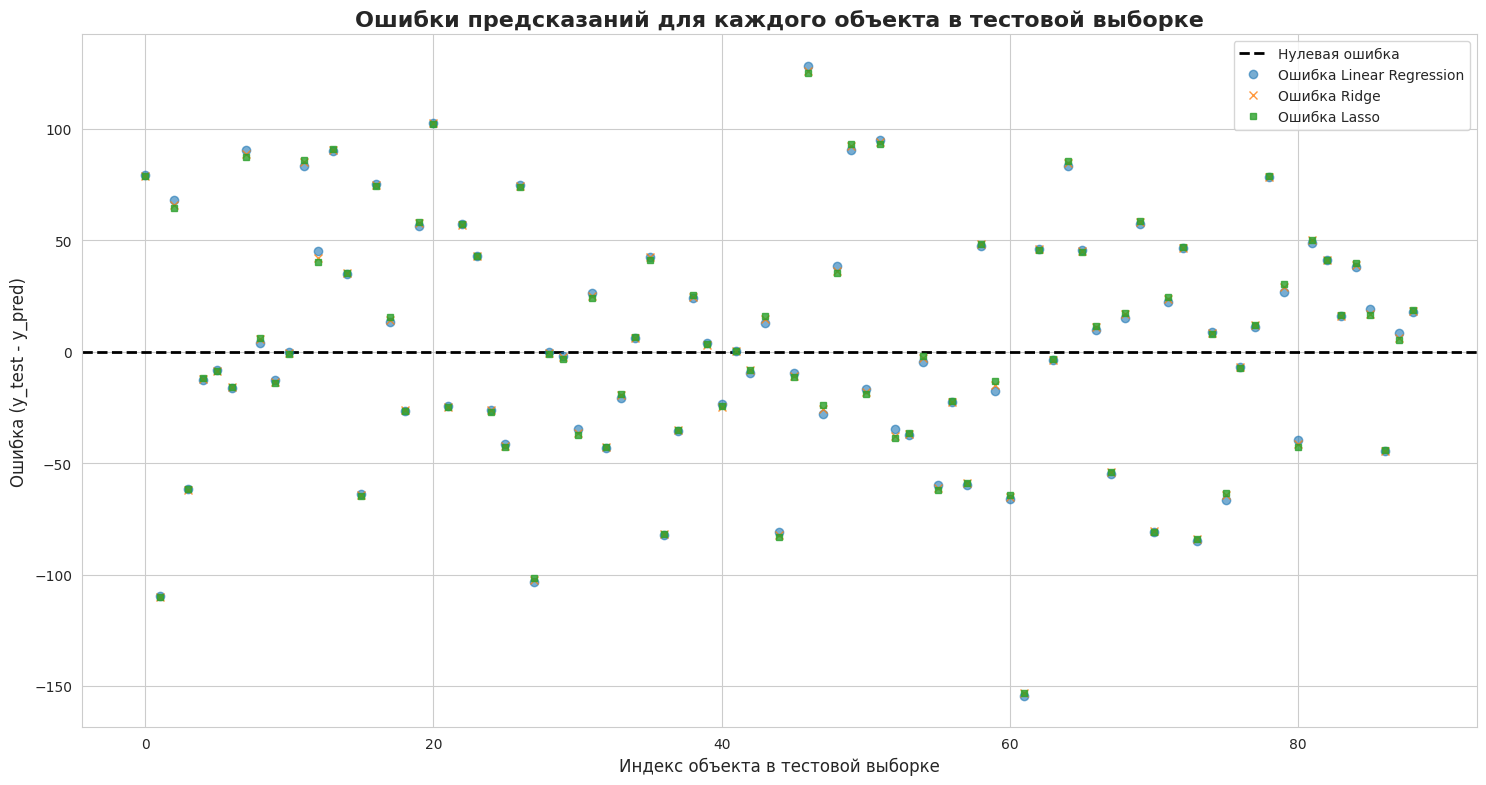

In [ ]:
lr_errors = y_test - lr_pred
ridge_errors = y_test - ridge_pred
lasso_errors = y_test - lasso_pred

x_axis = np.arange(len(y_test))

plt.figure(figsize=(18, 9))
sns.set_style("whitegrid")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2, label='Нулевая ошибка')

plt.plot(x_axis, lr_errors, marker='o', linestyle='', alpha=0.6, label='Ошибка Linear Regression')
plt.plot(x_axis, ridge_errors, marker='x', linestyle='', alpha=0.8, label='Ошибка Ridge')
plt.plot(x_axis, lasso_errors, marker='s', markersize=5, linestyle='', alpha=0.8, label='Ошибка Lasso')

plt.title('Ошибки предсказаний для каждого объекта в тестовой выборке', fontsize=16, fontweight='bold')
plt.xlabel('Индекс объекта в тестовой выборке', fontsize=12)
plt.ylabel('Ошибка (y_test - y_pred)', fontsize=12)
plt.legend()
plt.show()

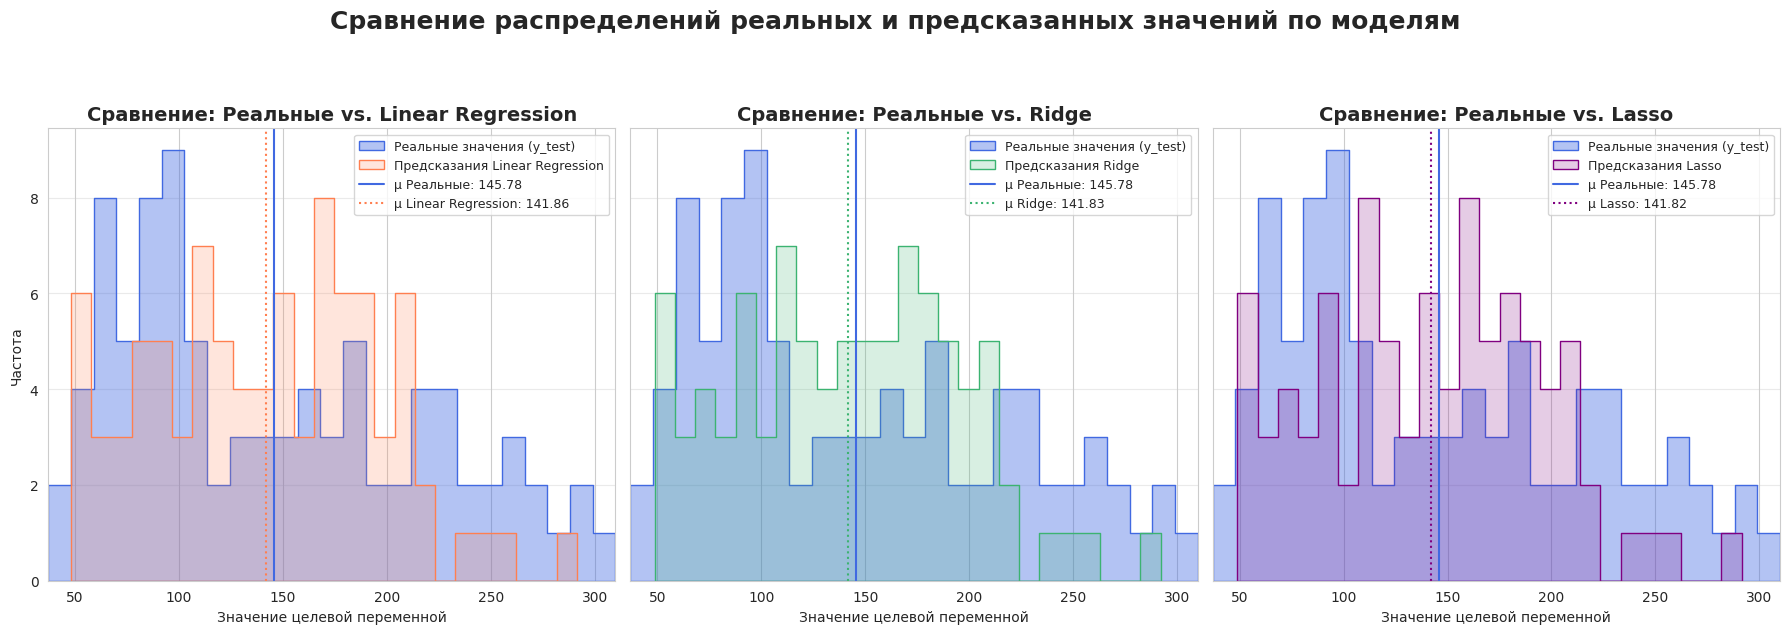

In [ ]:
plot_data = {
    'Linear Regression': lr_pred,
    'Ridge': ridge_pred,
    'Lasso': lasso_pred
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axes = axes.ravel()

colors_pred = ['coral', 'mediumseagreen', 'purple']
color_true = 'royalblue'
bins = 25

all_values = np.concatenate([y_test, lr_pred, ridge_pred, lasso_pred])
x_min, x_max = all_values.min(), all_values.max()

common_hist_params = {
    'x': y_test,
    'color': color_true,
    'alpha': 0.4,
    'bins': bins,
    'label': 'Реальные значения (y_test)',
    'element': 'step',
    'line_kws': {'linewidth': 2}
}

for i, (model_name, pred_data) in enumerate(plot_data.items()):
    ax = axes[i]

    sns.histplot(ax=ax, **common_hist_params)

    sns.histplot(
        x=pred_data,
        ax=ax,
        color=colors_pred[i],
        alpha=0.2,
        bins=bins,
        label=f'Предсказания {model_name}',
        element='step',
        line_kws={'linewidth': 2, 'linestyle': '--'}
    )

    mean_true = np.mean(y_test)
    mean_pred = np.mean(pred_data)

    ax.axvline(mean_true, color=color_true, linestyle='-', linewidth=1.5,
               label=f'μ Реальные: {mean_true:.2f}')

    ax.axvline(mean_pred, color=colors_pred[i], linestyle=':', linewidth=1.5,
               label=f'μ {model_name}: {mean_pred:.2f}')

    ax.set_title(f'Сравнение: Реальные vs. {model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Значение целевой переменной')
    ax.set_ylabel('Частота')
    ax.grid(axis='y', alpha=0.4)
    ax.set_xlim(x_min, x_max)

    ax.legend(loc='upper right', fontsize=9)

plt.suptitle('Сравнение распределений реальных и предсказанных значений по моделям',
             fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### 2.3 Выводы для линейных моделей

Ну так, норм, но не очень

### 2.4 Обучение персептрона

Эпоха 1/500, Train MSE: 29631.56, Test MSE: 26378.21
Эпоха 50/500, Train MSE: 2822.88, Test MSE: 2927.57
Эпоха 100/500, Train MSE: 2640.74, Test MSE: 2763.24
Эпоха 150/500, Train MSE: 2540.30, Test MSE: 2661.54
Эпоха 200/500, Train MSE: 2462.62, Test MSE: 2627.28
Эпоха 250/500, Train MSE: 2408.82, Test MSE: 2616.83
Эпоха 300/500, Train MSE: 2332.41, Test MSE: 2640.98
Эпоха 350/500, Train MSE: 2264.48, Test MSE: 2606.50
Эпоха 400/500, Train MSE: 2193.65, Test MSE: 2609.08
Эпоха 450/500, Train MSE: 2116.30, Test MSE: 2632.01
Эпоха 500/500, Train MSE: 2034.64, Test MSE: 2640.57
Обучение завершено.

--- Результаты оценки на тестовом наборе ---
Среднеквадратичная ошибка (MSE): 2640.57
Корень из среднеквадратичной ошибки (RMSE): 51.39


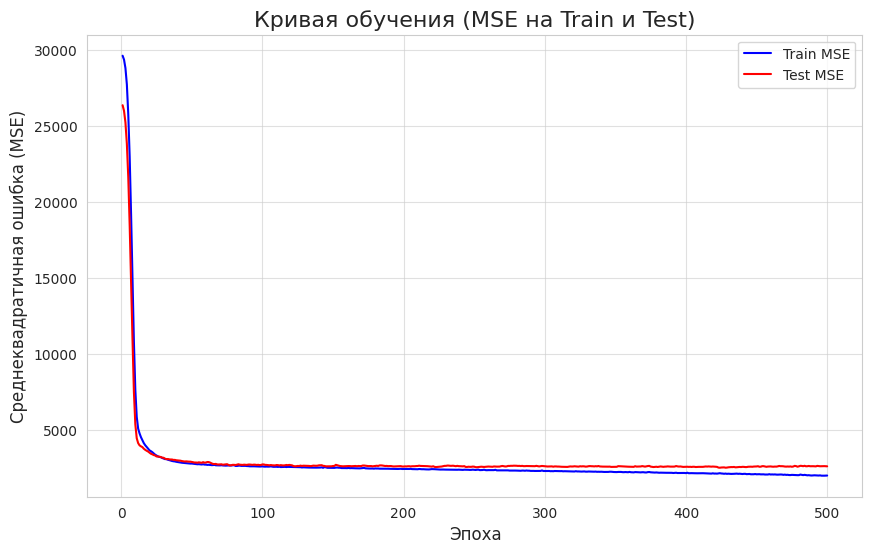

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        #self.fc2 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc3(x))
        return self.output(x)

INPUT_SIZE = X_train_t.shape[1]
model = MLP(INPUT_SIZE)

criterion = nn.MSELoss()

LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

NUM_EPOCHS = 500

train_losses = []
test_losses = []
epochs_list = []

def evaluate_test_loss(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
    return total_loss / len(test_loader.dataset)

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    test_epoch_loss = evaluate_test_loss(model, test_loader, criterion)

    train_losses.append(epoch_loss)
    test_losses.append(test_epoch_loss)
    epochs_list.append(epoch + 1)

    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f'Эпоха {epoch+1}/{NUM_EPOCHS}, Train MSE: {epoch_loss:.2f}, Test MSE: {test_epoch_loss:.2f}')

print("Обучение завершено.")

all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)

        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

predictions = np.concatenate(all_predictions).flatten()
targets = np.concatenate(all_targets).flatten()

mse = mean_squared_error(targets, predictions)
rmse = np.sqrt(mse)

print("\n--- Результаты оценки на тестовом наборе ---")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Корень из среднеквадратичной ошибки (RMSE): {rmse:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(epochs_list, train_losses, label='Train MSE', color='blue')
plt.plot(epochs_list, test_losses, label='Test MSE', color='red')
plt.title('Кривая обучения (MSE на Train и Test)', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Среднеквадратичная ошибка (MSE)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.6)
plt.show()